# Projet - Real or Not ? NLP with Disaster Tweets
[kaggle competition](https://www.kaggle.com/c/nlp-getting-started)

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS

import wordcloud

In [2]:
train = pd.read_csv("data/train.csv", index_col=0)

In [3]:
test = pd.read_csv("data/test.csv", index_col=0)

In [4]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.describe(include="all")

,keyword,location,text,target
count,7552,5080,7613,7613.00000
unique,221,3341,7503,NaN
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,45,104,10,NaN
mean,NaN,NaN,NaN,0.42966
std,NaN,NaN,NaN,0.49506
min,NaN,NaN,NaN,0.00000
25%,NaN,NaN,NaN,0.00000
50%,NaN,NaN,NaN,0.00000
75%,NaN,NaN,NaN,1.00000


## EDA - Distribution de la target

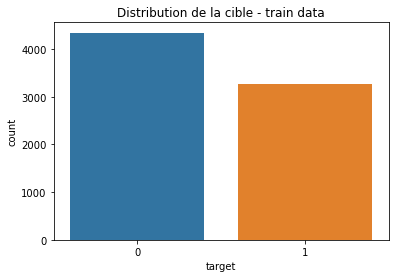

In [7]:
fig, ax = plt.subplots()
sns.countplot(data=train, x="target", ax=ax);
ax.set_title("Distribution de la cible - train data")
plt.show()

## Preprocessing

In [8]:
nlp = en_core_web_lg.load()

In [9]:
# suppresion des url
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [10]:
train["text"] = train["text"].map(remove_URL)
test["text"] = test["text"].map(remove_URL)

In [11]:
train["tokens"] = train["text"].apply(lambda x: nlp.tokenizer(x))
test["tokens"] = test["text"].apply(lambda x: nlp.tokenizer(x))

In [12]:
# lower case
train["tokens"] = train["tokens"].apply(lambda x: x.text.lower())
test["tokens"] = test["tokens"].apply(lambda x: x.text.lower())

In [21]:
corpus = " ".join([t.strip() for t in train["text"].to_list()])# + " " + " ".join([t.strip() for t in test["text"].to_list()])

In [22]:
len(corpus)

668457

In [23]:
corpus[:100]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all Forest fire near La Ronge Sask'

In [24]:
%%time

doc = nlp(corpus)

Wall time: 14.4 s


In [25]:
train.head()

,keyword,location,text,target,tokens
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...


## Wordcloud

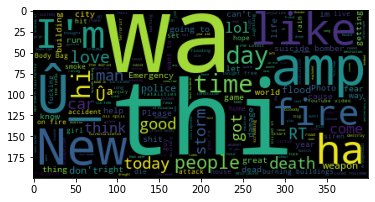

In [26]:
wd = wordcloud.WordCloud(stopwords=STOP_WORDS)
cloud = wd.generate(doc.text)
plt.imshow(cloud);

In [27]:
vocabulary_set = set([t.lemma_ for t in doc if t.lemma_ not in STOP_WORDS])
len(vocabulary_set)

18334

In [28]:
for t in range(20):
    print(list(vocabulary_set)[t])

Add
AUSTRALIA
@__srajapakse
kesabaran
kotolily
@Fantosex
miì
JANICE
Labour
Lessons
Sun.-MUSHROOM
rate
Ave
master0fsloths
STATE
import
Vets
@Reince
captivity
talisman


## Encoding

In [29]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [30]:
encoder.vocab_size

18336

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices((train["tokens"].values, train["target"].values))

In [32]:
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

# Utilisation du fonction py_function pour encoder tout le dataset 
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_train = train_ds.map(encode_map_fn)

In [33]:
inp, targ = next(iter(all_encoded_train))

In [34]:
inp, targ

(<tf.Tensor: shape=(13,), dtype=int64, numpy=
 array([18335, 18335, 18335, 18335, 18294, 18335, 18335,  9397, 18335,
        18335,  1016, 18335, 18335], dtype=int64)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

## Split train test

In [35]:
BATCH_SIZE = 32

train_size = int(0.7*train.shape[0])

train_data = all_encoded_train.take(train_size).shuffle(train_size)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))

test_data = all_encoded_train.skip(train_size).padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))

### Learning rate

In [54]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

## Model

In [71]:
def get_model():
    return tf.keras.Sequential([
        # Couche d'Input Word Embedding           
        tf.keras.layers.Embedding(encoder.vocab_size+1, 4),

        # Couche LSTM Bidirectionnelle
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, dropout=0.2, kernel_regularizer=tf.keras.regularizers.l2(0.002), return_sequences=True)),
        
        # Couche CNN
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(8, 3, kernel_regularizer=tf.keras.regularizers.l2(0.002), activation="relu"),           

        # Couche Dense classique 
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),

        # Couche de sortie avec fonction sigmoïd classification binaire
        tf.keras.layers.Dense(1, activation="sigmoid")                                                  
])

In [72]:
model = get_model()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [73]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 4)           73348     
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 16)          832       
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 8)           392       
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 8)           0         
_________________________________________________________________
dense_16 (Dense)             (None, None, 4)           36        
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)          

## Training

In [74]:
history = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
167/167 [==============================] - 12s 74ms/step - loss: 0.6962 - binary_accuracy: 0.5744 - val_loss: 0.6890 - val_binary_accuracy: 0.5582
Epoch 2/5
167/167 [==============================] - 12s 70ms/step - loss: 0.6664 - binary_accuracy: 0.5755 - val_loss: 0.6533 - val_binary_accuracy: 0.5582
Epoch 3/5
167/167 [==============================] - 12s 70ms/step - loss: 0.5614 - binary_accuracy: 0.7065 - val_loss: 0.6164 - val_binary_accuracy: 0.7328
Epoch 4/5
167/167 [==============================] - 12s 70ms/step - loss: 0.4881 - binary_accuracy: 0.8500 - val_loss: 0.6179 - val_binary_accuracy: 0.7294
Epoch 5/5
167/167 [==============================] - 12s 70ms/step - loss: 0.4419 - binary_accuracy: 0.8767 - val_loss: 0.6310 - val_binary_accuracy: 0.7247


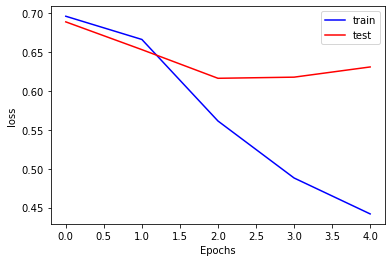

In [75]:
# Visualisation du processus d'entrainement sur la loss function 
plt.plot(history.history["loss"], color="b", label="train")
plt.plot(history.history["val_loss"], color="r", label="test")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

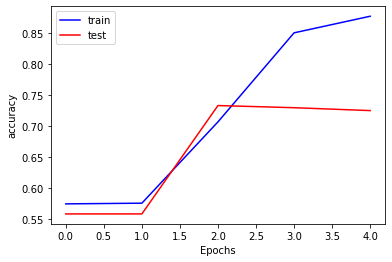

In [76]:
plt.plot(history.history["binary_accuracy"], color="b", label="train")
plt.plot(history.history["val_binary_accuracy"], color="r", label="test")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()